<a href="https://colab.research.google.com/github/MerveCura/yolo-object-detection-myPhoto/blob/main/yolo_object_detection_myPhoto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
%%capture
# Colab için “sabit kurulum” hücresi — her oturumda İLK çalıştırılacak
%pip install -q --no-cache-dir --upgrade pip

# 1) NumPy'ı uyumlu sürüme sabitle
%pip install -q --no-cache-dir --force-reinstall "numpy==1.26.4"

# 2) NumPy'a bağlı derlenmiş paketleri UYUMLU sürümlere kur
%pip install -q --no-cache-dir --force-reinstall \
  "ultralytics==8.2.0" \
  "opencv-python" \
  "pillow" \
  "matplotlib" \
  "scipy"


In [37]:
%%capture --no-stderr
!pip install -q ultralytics==8.3.0 numpy==1.26.4 opencv-python-headless==4.9.0.80


In [29]:
print("==Kurulum Doğrulama==")
import numpy as np, sys
import ultralytics
try:
  import cv2
  cv2_ver = cv2.__version__
except Exception as e:
  cv2_ver = f"Yok/Yüklenemedi ->{e}"

print("Python: ", sys.version.split()[0])
print("NumPy: ", np.__version__)
print("OpenCv:  ", cv2_ver)
print("Ultralytics: ", ultralytics.__version__)
print("Durum: OK ")

==Kurulum Doğrulama==
Python:  3.11.13
NumPy:  1.26.4
OpenCv:   4.11.0
Ultralytics:  8.3.0
Durum: OK 


In [30]:
print("==GPU Kontrolü==")
!nvidia-smi

==GPU Kontrolü==
Tue Aug 12 22:10:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             30W /   70W |     200MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------

In [31]:
print("==Import + CUDA Testi==")
from ultralytics import YOLO
import torch

print("Pytorch Sürümü: ", torch.__version__)
print("CUDA Kullanılabilir Mi?", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Kullanılacak Cihaz: ", device)

==Import + CUDA Testi==
Pytorch Sürümü:  2.6.0+cu124
CUDA Kullanılabilir Mi? True
Kullanılacak Cihaz:  cuda


In [32]:
print("==Modeli Yükleyelim==")
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
class_names = list(model.names.values())
print("Toplam Sınıf: ", len(class_names))
print("İlk 10 Sınıf: ", class_names[:10])

==Modeli Yükleyelim==
Toplam Sınıf:  80
İlk 10 Sınıf:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']


In [33]:
print("==Görseli Hazırlayalım")

from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded)) if uploaded else None
if image_path:
  print("Yüklenen Dosya: ", image_path)
else:
  print("Herhangi bir dosya yüklenemedi.")


==Görseli Hazırlayalım


Saving florya.jpg to florya (5).jpg
Yüklenen Dosya:  florya (5).jpg


In [34]:
print("==Tahmin==")

from pathlib import Path
from ultralytics import YOLO
import torch

# Define model and device here
model = YOLO("yolov8n.pt")
device = "cuda" if torch.cuda.is_available() else "cpu"


def run_predict(img_path):
    print(f"\n-> Tahmin çalışıyor: {img_path}")
    results = model.predict(
        source=img_path,
        conf=0.25,
        save=True,
        device=0 if device == 'cuda' else 'cpu'
    )
    r = results[0]
    out_img = Path(r.save_dir) / Path(r.path).name
    print("Kaydedilen çıktı   :", out_img)
    print("Bulunan kutu sayısı:", 0 if r.boxes is None else len(r.boxes))
    return out_img, r

out_custom, r_custom = (None, None)
if image_path:
    out_custom, r_custom = run_predict(image_path)

print("\nTahmin tamam ")

==Tahmin==

-> Tahmin çalışıyor: florya (5).jpg

image 1/1 /content/florya (5).jpg: 480x640 2 persons, 1 car, 2 benchs, 7.2ms
Speed: 5.5ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict6
Kaydedilen çıktı   : runs/detect/predict6/florya (5).jpg
Bulunan kutu sayısı: 5

Tahmin tamam 


==Sonucu Göster==


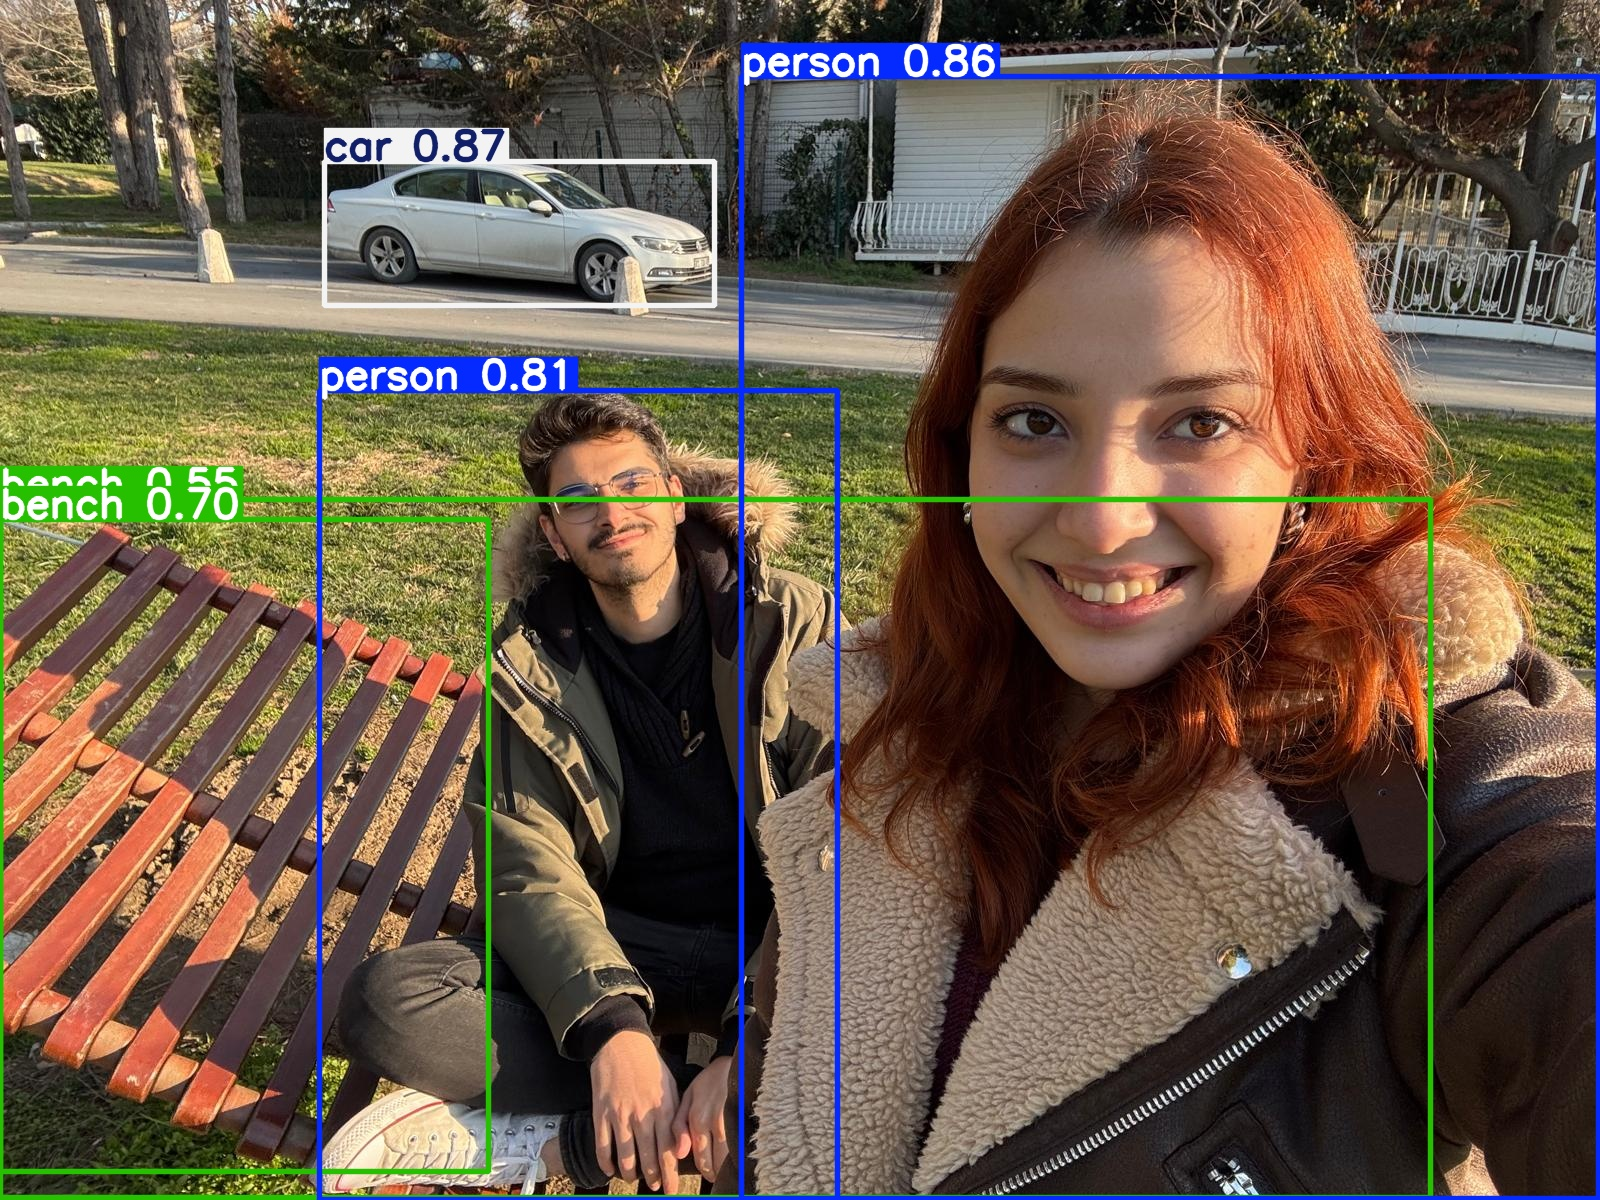

Gösterildi:  runs/detect/predict6/florya (5).jpg


In [35]:
print("==Sonucu Göster==")
from IPython.display import Image, display
from pathlib import Path

if out_custom and Path(out_custom).exists():
    display(Image(filename=str(out_custom), width=500))
    print("Gösterildi: ", out_custom)
else:
    print("Çıktı görseli bulunamadı")



In [36]:
print("==Tespit Listesi==")

def list_detections(r):
  if not r or r.boxes is None or len(r.boxes)==0:
    print("Hiç tespit yok :( ")
    return
  names = model.names
  print(f"{len(r.boxes)} adet nesne tespit edildi: ")
  for i, box in enumerate(r.boxes, start=1):
    cls_id = int(box.cls.item())
    cls_name = names[cls_id]
    conf = float(box.conf.item())
    xyxy = [round(float(x), 1) for x in box.xyxy[0].tolist()]
    print(f"{i:02d}. {cls_name:>12} | Güven: {conf:.2f} | Kutu: {xyxy}")

list_detections(r_custom)

==Tespit Listesi==
5 adet nesne tespit edildi: 
01.          car | Güven: 0.87 | Kutu: [324.0, 161.0, 714.4, 305.8]
02.       person | Güven: 0.86 | Kutu: [741.1, 76.0, 1598.1, 1198.5]
03.       person | Güven: 0.81 | Kutu: [319.5, 390.6, 838.0, 1199.7]
04.        bench | Güven: 0.70 | Kutu: [0.4, 519.8, 488.8, 1171.4]
05.        bench | Güven: 0.55 | Kutu: [0.4, 499.3, 1430.3, 1197.4]
